- **Module:** read_aeronet_time_series.ipynb
- **Authors:** Petar Grigorov and Pawan Gupta
- **Organization:**NASA AERONET (https://aeronet.gsfc.nasa.gov/)
- **Date:** 2023-07-03
- **Last Revision:** 2023-07-24
- **Purpose:** Time-series analysis of AERONET sites AOD levels
- **Disclaimer:** The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.
- **Contact:** report any concern or question related to the code to pawan.gupta@nasa.gov or petar.t.grigorov@nasa.gov

**Required packages installation and importing**

In [ ]:
!pip install beautifulsoup4
!pip install requests
!pip install calplot

from bs4 import BeautifulSoup      #reads data from website (web scraping)
import requests                    #useful for sending HTTP requests
import shutil                      #useful for creating zip files
import math                        #useful math operations
import numpy as np                 #for array manipulation
from numpy import arange           #range of values for testing purposes
import datetime                    #for time data manipulation
import pandas as pd                #for data querying and processing
import matplotlib.pyplot as plt    #for creating plots
import calplot                     #for creating heat maps
from collections import Counter    #for keeping track of unique data

from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8116 sha256=e342aaa5b2388b74e2c073fa879391c84ed7a054678a1e584cb6a06f9c1c95cb
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


**Connecting and mounting local drive onto colab notebook**

In [ ]:
from google.colab import files      #ensures output zip file can be downloaded
from google.colab import drive      #imports local google drive
drive.mount('/drive')               #mounts local google drive onto colab
!mkdir Output_TimeSeries            #makes directory where output files will be stored

Mounted at /drive


**Setup input parameters such as date, data level, averaging type, AOD range for mapping, AOD/Angstrom exponent, and geographical limits**

In [ ]:
site = 'Alta_Floresta'                           #Please make sure site name is spelled properly
dt_initial = '20010101'                 #starting date YYYYMMDD format
dt_final = '20230728'                   #final date YYYYMMDD format
level = 1.5                             #AERONET data level
average_type = 1                        #daily (1), monthly (2)
feature_choice = 1                      #Enter '1' if you are specifying an AOD wavelength or '2' if you are specifying an Angstrom exponent
wavelength = 500                        #Available choices: 1640, 1020, 870, 865, 779, 675, 667, 620, 560, 555, 551, 532, 531, 510, 500, 490, 443, 440, 412, 400, 380, 340
Angstrom_exp = '440-675'                #Available choices: '440-870','380-500','440-675','500-870','340-440','440-675'

**Get desired AERONET data using web services, then scraping data from website**

In [ ]:
yr_initial = dt_initial[:4]               #initial year
mon_initial = dt_initial[4:6]             #initial month
day_initial = dt_initial[6:]              #initial day

yr_final = dt_final[:4]                   #final year
mon_final = dt_final[4:6]                 #final month
day_final = dt_final[6:]                  #final day

if level == 1 or level == 1.0:
  level = 10
elif level == 1.5:
  level = 15
elif level == 2 or level == 2.0:
  level = 20
else:
  print("\nIncorrect input for data level type. Defaulting to level 1.5...")
  level = 15

if average_type == 1:
  max_days = 60
elif average_type == 2:
  max_days = 1800
else:
  average_type = 2
  max_days = 1800
  print("\nIncorrect input for average type. Defaulting to monthly averages (2)...")

if level == 20 and int(yr_initial) == datetime.date.today().year:                 #if user wants level 2 data for the current year, program alerts that data may not be available
  level = 15                                                                      #defaults to level 1.5 data
  print("\nThere is no level 2 data available for the current year. Defaulting to level 1.5 data...")

date_initial = pd.to_datetime(dt_initial)
date_final = pd.to_datetime(dt_final)
delta = date_final - date_initial

if delta.days > max_days:
  print("\nNote that the selected time frame is very large, which may cause the time series graphs to look very cluttered.")

base_web = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=',site,'&year=',yr_initial,'&month=',mon_initial,'&day=',day_initial,'&year2=',yr_final,'&month2=',mon_final,'&day2=',day_final,'&AOD',level,'=1&AVG=20'

def convertTuple(tup):              #this function converts the url above from tuple to a string. It basically removes the commas.
    st = ''.join(map(str, tup))
    return st

url = convertTuple(base_web)        #URL tuple is passed, and converted to strrng

soup = BeautifulSoup(requests.get(url).text) #web services contents are read here from URL

if len(soup) <= 1:                    #alerts the user if the data cannot be read due to improper parameter inputs
  print("\nThe link could not be generated due to issues with the date and/or site input. Please try again.")


Note that the selected time frame is very large, which may cause the time series graphs to look very cluttered.


**Writes soup data to text file, then assigns contents to Pandas dataframe**

In [ ]:
with open(r'/content/Test.txt' ,"w") as oFile:          #writes the data scraped from "beautiful soup" to a text file on your local Google drive
    oFile.write(str(soup.text))
    oFile.close()

df = pd.read_csv(r'/content/Test.txt',skiprows = 5)     #loads the csv data into a Pandas dataframe

**Read and filter downloaded data as per user average type specification**

In [ ]:
df = df.replace(-999.0, np.nan)                                     #replaces all -999.0 vakyes with NaN; helps with accurate data aggregation
df[['Day','Month','Year']] = df['Date(dd:mm:yyyy)'].str.split(':',expand=True)                                #splits the date column and then joins it back together using "-" instead of ":"
df['Date'] = df[['Year','Month','Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")       #because datetime format in python does not recognize colons
df['Date']= pd.to_datetime(df['Date'])                                              #converts the new date column to datetime format

**AOD Wavelength or Angstrom Exponent Selection**

In [ ]:
AOD_col = ['AOD_1640nm','AOD_1020nm','AOD_870nm','AOD_865nm','AOD_779nm','AOD_675nm','AOD_667nm','AOD_620nm','AOD_560nm',
       'AOD_555nm','AOD_551nm','AOD_532nm','AOD_531nm','AOD_510nm','AOD_500nm','AOD_490nm','AOD_443nm','AOD_440nm',
       'AOD_412nm','AOD_400nm','AOD_380nm','AOD_340nm']                                                   #list of AOD columns, used for mapping user input to them

Ang_exp_col = ['440-870_Angstrom_Exponent','380-500_Angstrom_Exponent','440-675_Angstrom_Exponent',
               '500-870_Angstrom_Exponent','340-440_Angstrom_Exponent','440-675_Angstrom_Exponent']       #list of Angstrom Exponent columns, used for mapping user input to them

AOD_val = [1640, 1020, 870, 865, 779, 675, 667, 620, 560, 555, 551, 532, 531, 510, 500, 490, 443, 440, 412, 400, 380, 340]   #expected user input choices for AOD
Ang_exp_val = ['440-870','380-500','440-675','500-870','340-440','440-675']                                                  #expected user input choices for AE

if feature_choice == 1:
  if wavelength in AOD_val:             #if user input for AOD wavelength matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(AOD_col)):
      if wavelength == AOD_val[i]:      #code scans the list of columns and list of possible values, and matches user input to the appropriate column name
        df = df[['Date','Day_of_Year',AOD_col[i]]]         #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Date','Day_of_Year','AOD_500nm']]
    print("\nInput for AOD wavelength is not in list. Defaulting to 500nm...")
elif feature_choice == 2:
  if Angstrom_exp in Ang_exp_val:     #if user input for Angstrom Exponent matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(Ang_exp_col)):
      if Angstrom_exp == Ang_exp_val[i]:  #code scans the list of columns and list of possible values, and matches user input to the appropriate column nam
        df = df[['Date','Day_of_Year',Ang_exp_col[i]]]     #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Date','Day_of_Year','440-675']]
    print("\nInput for Angstrom Exponent is not in list. Defaulting to 440-675...")
else:
  feature_choice == 1
  print("\nIncorrect input for feature choice. Defaulting to AOD wavelength (1)...")
  if wavelength in AOD_val:             #if user input for AOD wavelength matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(AOD_col)):
      if wavelength == AOD_val[i]:      #code scans the list of columns and list of possible values, and matches user input to the appropriate column name
        df = df[['Date','Day_of_Year',AOD_col[i]]]         #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Date','Day_of_Year','AOD_500nm']]
    print("\nInput for AOD wavelength is not in list. Defaulting to 500nm...")

df = df.dropna().reset_index(drop=True) #Drops NaN or -999.0 values

**Descriptive statistics**

In [ ]:
x=df[df.columns[-1]]
x.describe()

count    3615.000000
mean        0.322233
std         0.464292
min         0.012392
25%         0.082423
50%         0.139630
75%         0.366669
max         4.703716
Name: AOD_500nm, dtype: float64

**Time-series analysis**

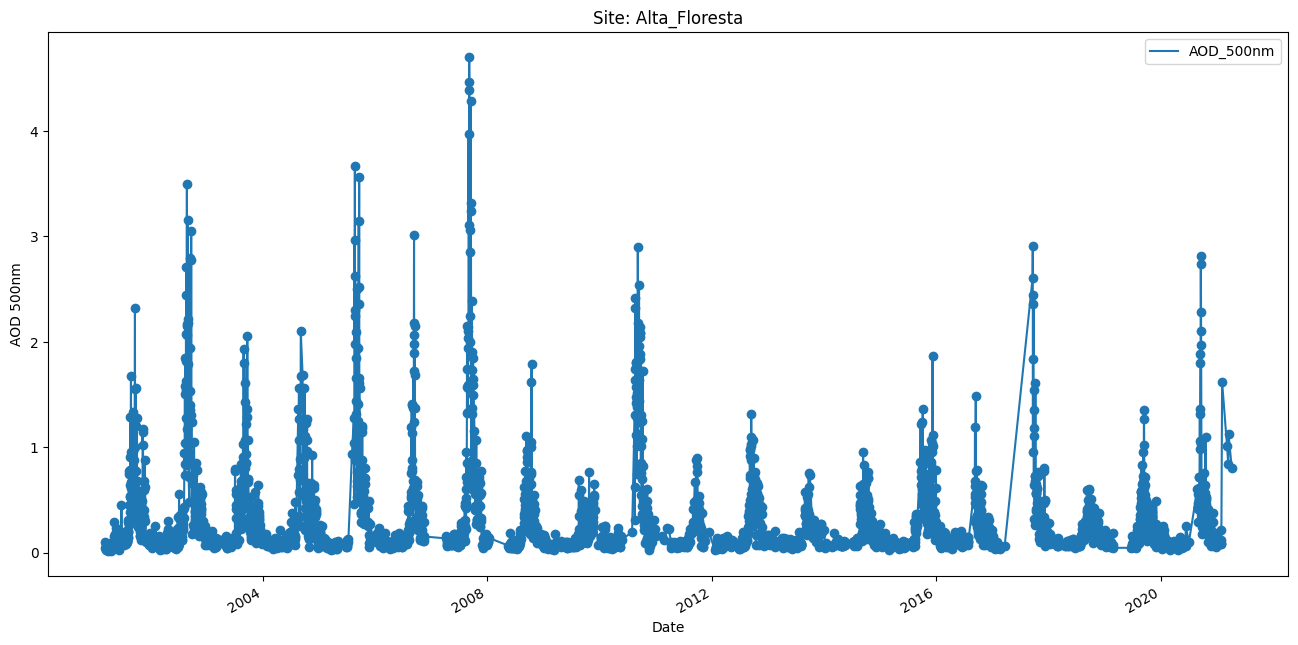

In [ ]:
if average_type == 2:
  df = df.groupby(pd.PeriodIndex(df['Date'], freq="M")).mean().reset_index()

plot = df.plot('Date', df.columns[-1], title = "Site: "+str(site), figsize=(16,8))
plt.scatter(df['Date'], df[df.columns[-1]])    #superimposed scatter plot of points, in addition to the line graph
plt.ylabel(df.columns[-1].replace('_', ' '))
fig = plot.get_figure()
fig.savefig('/content/Output_TimeSeries/TimeSeries_'+str(site)+'.png')               #saves figure
plt.show()

**Tile Map of Time Series**

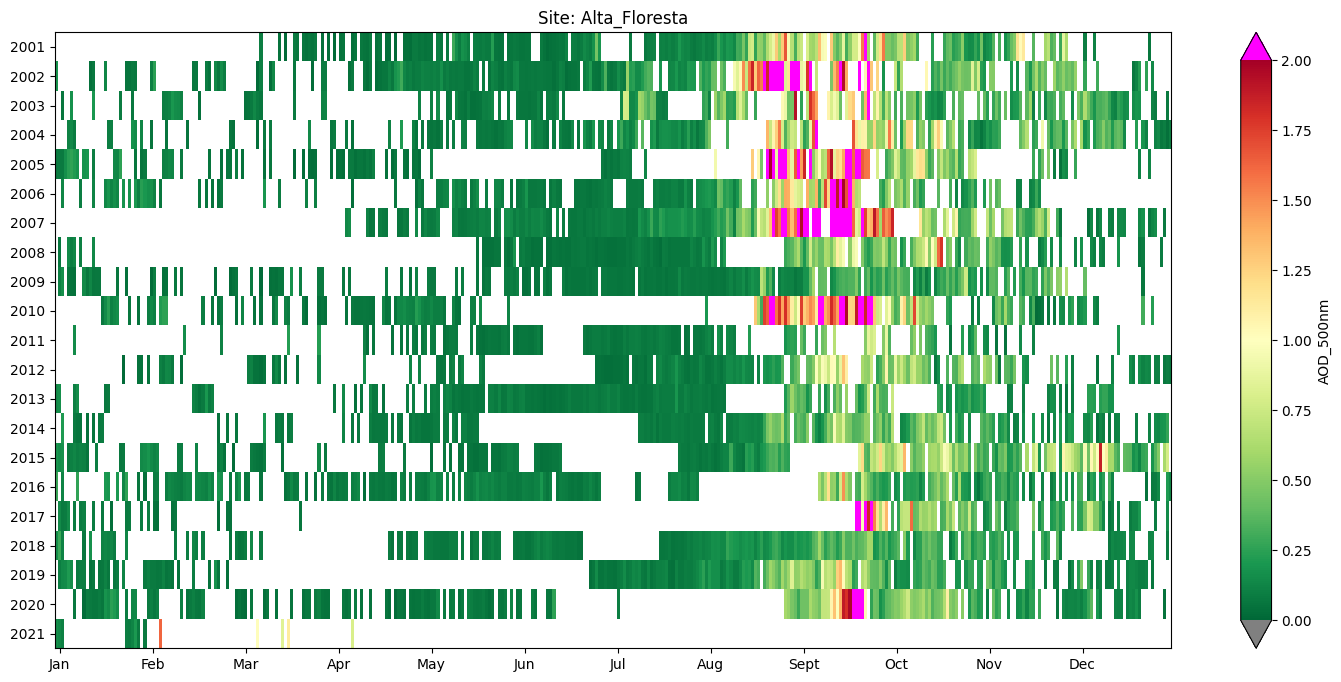

In [ ]:
if average_type == 1:
  df[['Year','Month','Day']] = df['Date'].astype(str).str.split('-',expand=True)
  df = df.drop(columns = ['Month','Day'])
  df['Year'] = df['Year'].astype(int)

  # Extracting year, month, and values from the data
  years = df['Year'].to_list()
  days = df['Day_of_Year'].to_list()
  months = [1,2,3,4,5,6,7,8,9,10,11,12]
  values = df.iloc[:,2].to_list()

  # Creating a 2D matrix to represent the heatmap
  heatmap = np.zeros((max(years) - min(years) + 1, max(days)))

  # Populating the heatmap with values
  for i in range(len(df)):
      year_index = years[i] - min(years)
      day_index = days[i] - 1
      heatmap[year_index, day_index] = values[i]

  #assign all zeroes (missing values) in heatmap matrix as NaN so that matplotlib set_bad function can work
  num_rows, num_cols = heatmap.shape
  for i in range(num_rows):
    for j in range(num_cols):
      if heatmap[i,j] == 0.0:
        heatmap[i,j] = 'NaN'

  # Plotting the heatmap
  plt.rcParams["figure.figsize"] = [18, 8]
  ax= plt.subplot()
  current_cmap = plt.cm.get_cmap('RdYlGn_r')
  current_cmap.set_bad(color = 'white')
  current_cmap.set_extremes(under='gray', over='magenta')
  plt.imshow(heatmap, cmap = current_cmap, interpolation='nearest', aspect='auto', vmin = 0, vmax = 2.0)
  plt.colorbar(label=df.columns[2], extend = 'both')
  plt.xticks(np.arange(min(days), max(days)+1, max(days)/max(months)))
  plt.yticks(np.arange(len(Counter(years).keys())), np.arange(min(years), max(years) + 1))
  ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'], fontsize=10)
  plt.title('Site: '+str(site), size=12)
  plt.savefig('/content/Output_TimeSeries/TilePlot_Daily_'+str(site)+'.png')
  plt.show()

elif average_type == 2:
  df[['Year','Month']] = df['Date'].astype(str).str.split('-',expand=True)
  df['Year'] = df['Year'].astype(int)
  df['Month'] = df['Month'].astype(int)

  # Extracting year, month, and values from the data
  years = df['Year'].to_list()
  months = df['Month'].to_list()
  values = df.iloc[:,2].to_list()

  # Creating a 2D matrix to represent the heatmap
  heatmap = np.zeros((max(years) - min(years) + 1, max(months)))

  # Populating the heatmap with values
  for i in range(len(df)):
      year_index = years[i] - min(years)
      month_index = months[i] - 1
      heatmap[year_index, month_index] = values[i]

  #assign all zeroes (missing values) in heatmap matrix as NaN so that matplotlib set_bad function can work
  num_rows, num_cols = heatmap.shape
  for i in range(num_rows):
    for j in range(num_cols):
      if heatmap[i,j] == 0.0:
        heatmap[i,j] = 'NaN'

  # Plotting the heatmap
  plt.rcParams["figure.figsize"] = [12, 8]
  ax= plt.subplot()
  current_cmap = plt.cm.get_cmap('RdYlGn_r')
  current_cmap.set_bad(color = 'white')
  current_cmap.set_extremes(under='gray', over='magenta')
  plt.imshow(heatmap, cmap = current_cmap, interpolation='nearest', aspect='auto')
  plt.colorbar(label=df.columns[2], extend = 'both')
  plt.xticks(np.arange(len(Counter(months).keys())), np.arange(1, len(Counter(months).keys()) + 1))
  plt.yticks(np.arange(len(Counter(years).keys())), np.arange(min(years), max(years) + 1))
  ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'], fontsize=10)
  plt.title('Site: '+str(site), size=12)
  plt.savefig('/content/Output_TimeSeries/TilePlot_Monthly_'+str(site)+'.png')
  plt.show()

**Calendar plot of Time series (Daily averages only)**

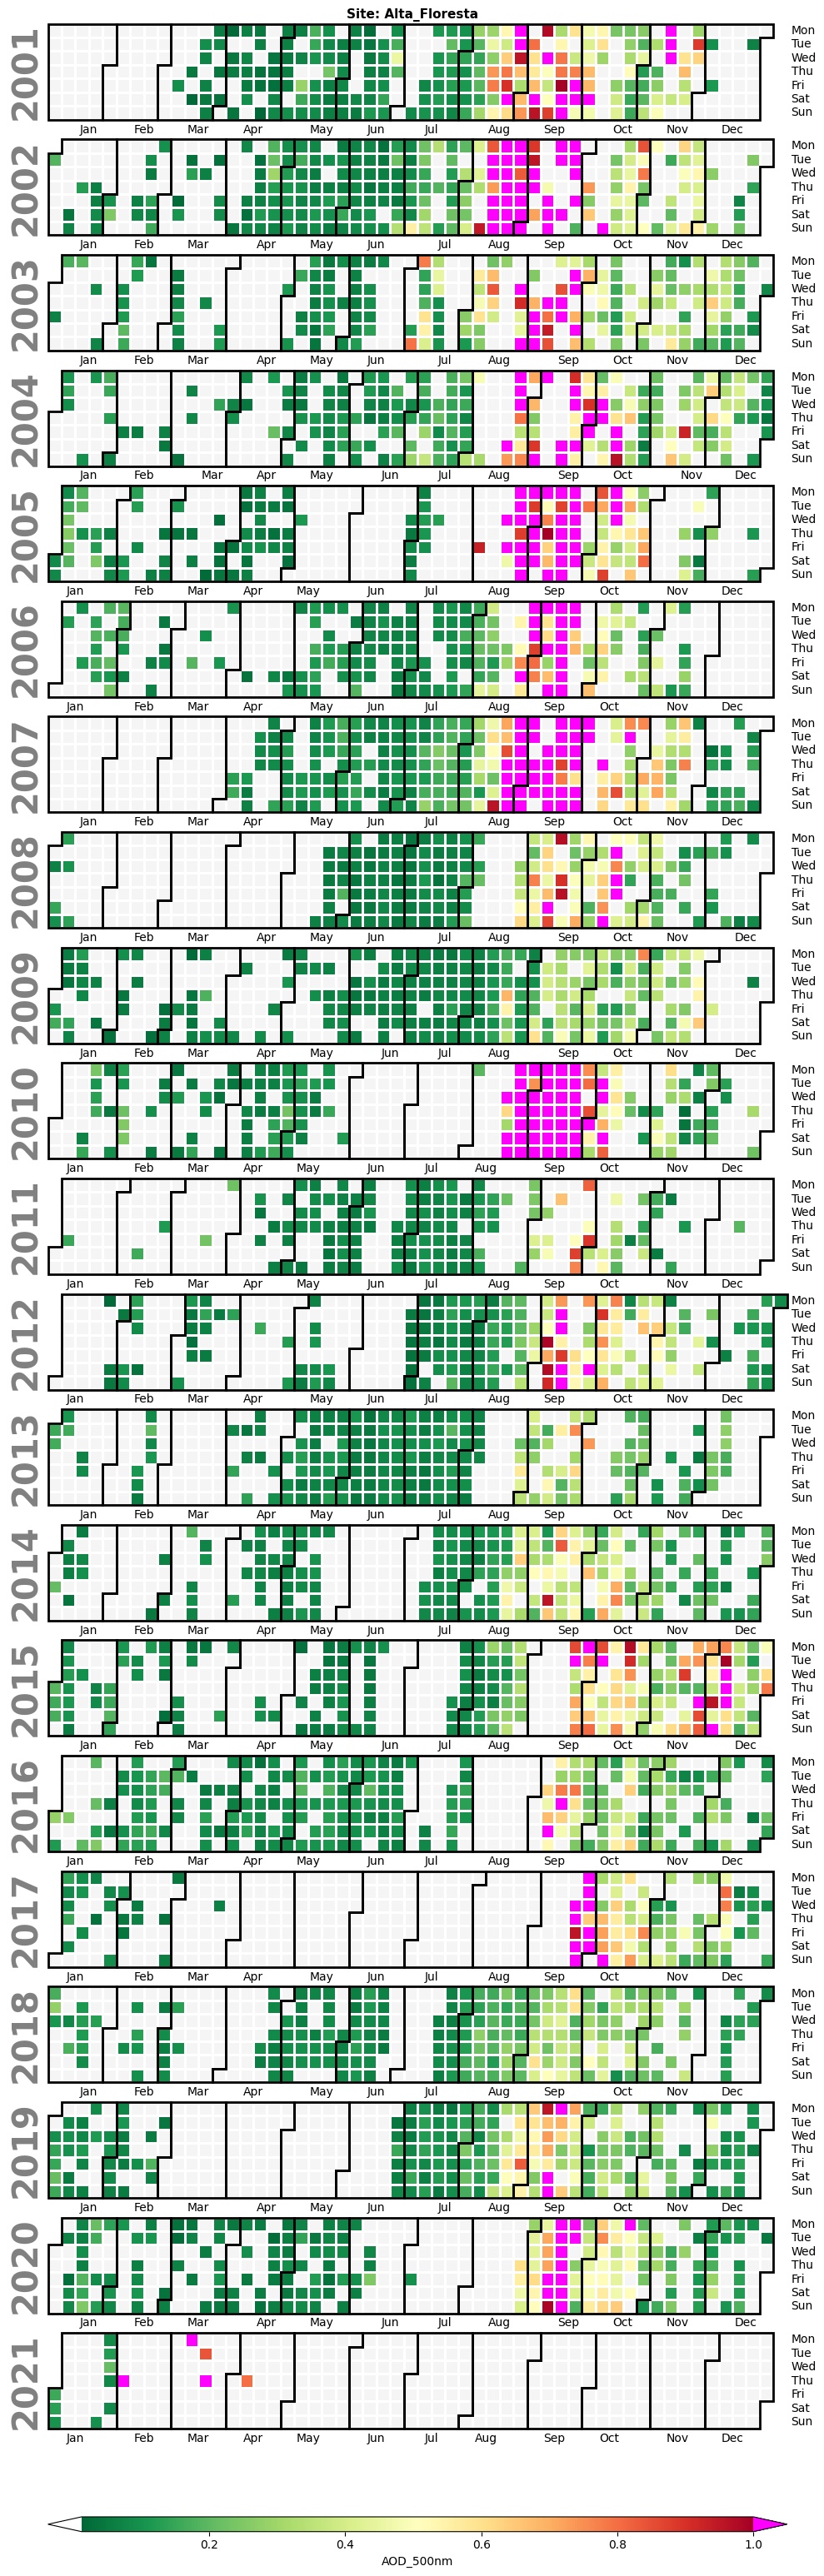

In [ ]:
if average_type == 1:

  df_cal = df.set_index('Date')
  df_cal.index = pd.DatetimeIndex(df_cal.index)
  df_cal = df_cal.reindex(pd.date_range(df['Date'].min(), df['Date'].max()), fill_value=0)

  current_cmap = plt.cm.get_cmap('RdYlGn_r')
  current_cmap.set_extremes(under='white', over='magenta')

  fig, ax = calplot.calplot(df_cal[df_cal.columns[1]], edgecolor='black', linewidth=2, colorbar=False,
                          suptitle="Site: "+str(site), suptitle_kws={'size': 11, 'weight':'bold'},
                          cmap = current_cmap, vmin=df[df.columns[2]].min(), vmax=1)

  fig.colorbar(ax[0].get_children()[1], ax = ax.ravel().tolist(), extend='both',
               orientation = 'horizontal', aspect = 50, pad = 0.03, label = df_cal.columns[1])

  plt.savefig('/content/Output_TimeSeries/CalendarPlot_Daily_'+str(site)+'.png', bbox_inches='tight')

**Machine Learning - Lasso Regression**

In [ ]:
df_Lasso = df[[df.columns[0],df.columns[2]]]
df_Lasso[df.columns[0]] = pd.to_datetime(df_Lasso[df.columns[0]])
df_Lasso[df.columns[0]]= df_Lasso[df.columns[0]].map(datetime.datetime.toordinal)

X, y = df_Lasso[[df.columns[0]]], df_Lasso[[df.columns[2]]] #splits dataframe into predictor variable X (time) and repsonse variable y (AOD)
X_train,X_test,y_train,y_test=X.iloc[0:int(0.8*len(df_Lasso))],X.iloc[int(0.8*len(df_Lasso)):len(df_Lasso)],y.iloc[0:int(0.8*len(df_Lasso))],y.iloc[int(0.8*len(df_Lasso)):len(df_Lasso)]
#splits variables into training and testing data, with training size of 80% and test size of 20%
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) #defines cross validation technique
modelLasso = LassoCV(alphas=arange(0,1,0.01), cv=cv, n_jobs=-1).fit(X_train,y_train) #uses Lasso regression and cross validation to fit model with different alpha values
print('Optimal alpha: %f' % modelLasso.alpha_) #prints the alpha value where the model had the best peformance

finalLasso = Lasso(alpha = modelLasso.alpha_).fit(X_train,y_train) #fits Lasso model once again with the optimal alpha using training dataset
y_hat_test = finalLasso.predict(X_test) #predicts AOD using the testing dataset
y_hat_train = finalLasso.predict(X_train) #predicts AOD using the training dataset
y_hat = np.concatenate((y_hat_train, y_hat_test)) #combines the predicted arrays into one
print('Testing MSE: %f' % mean_squared_error(y_hat_test, y_test)) #Uses Mean Squared Error metric to compares predicted AOD (y_hat) to actual AOD ones
print('Training MSE: %f' % mean_squared_error(y_hat_train, y_train))

Optimal alpha: 0.050000
Testing MSE: 0.133174
Training MSE: 0.233344


**Annual variability plot (Daily averages only)**

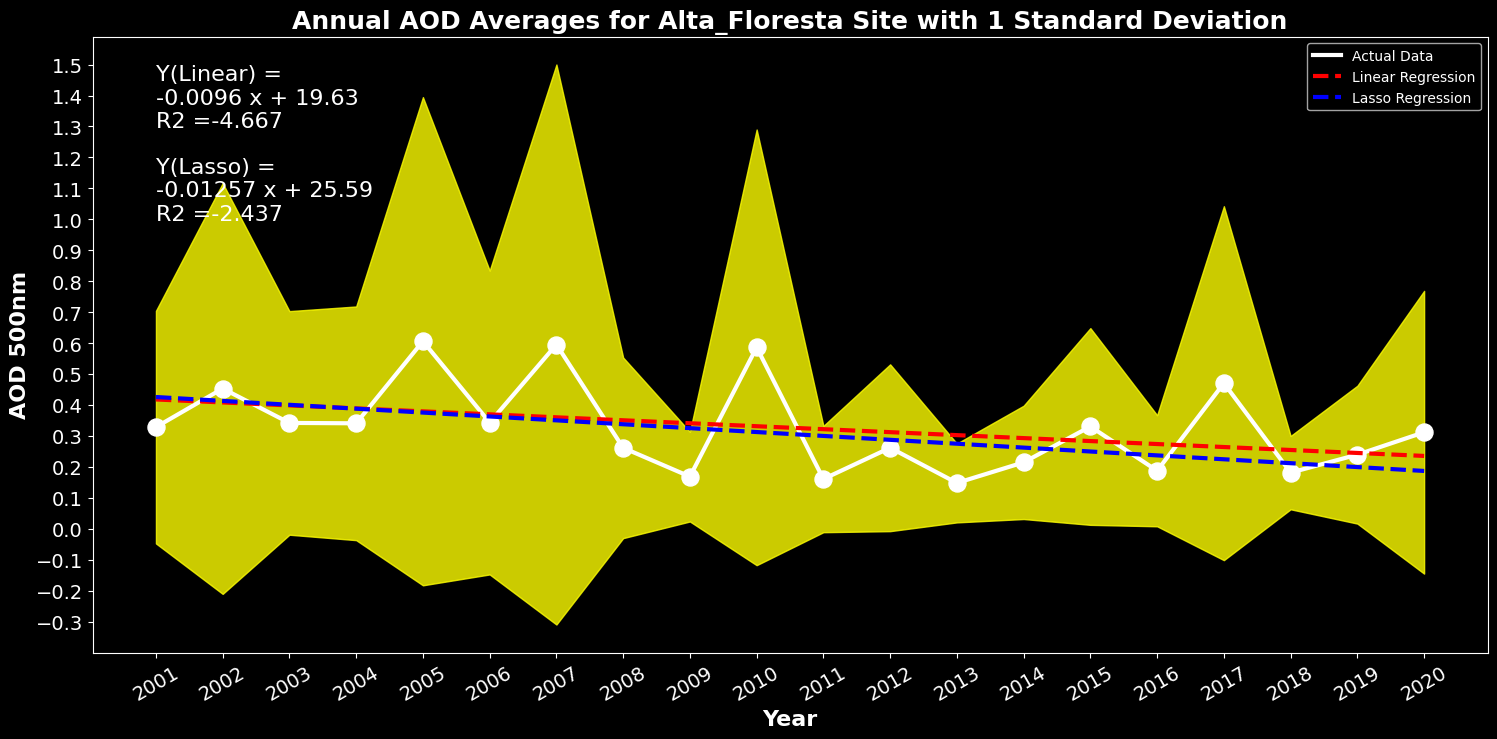

In [ ]:
if average_type == 1:
  df_annual = df[['Year',df.columns[2]]]   #isolates year and AOD columns to new dataframe
  df_annual['Predicted_Lasso'] = y_hat.tolist() #adds predicted AOD column from Lasso Regression to the dataframe
  df_annual = pd.merge(df_annual,df_annual.groupby(['Year']).size().reset_index().rename(columns = {0:"Count"})) #counts total number of yearly data
  df_annual = df_annual[df_annual.Count >= 30] #filters out years with less than 30 measurements
  df_annual = df_annual.drop(columns=['Count']).reset_index(drop=True) #drops Count column after filtering dataset

  df_sigma = df_annual.groupby(['Year']).std().reset_index()  #takes standard deviation of AOD measurements per year
  df_sigma = df_sigma.rename(columns={df.columns[2]:df.columns[2]+str('_sigma')})  #assigns standard deviation column name
  df_miu = df_annual.groupby(['Year']).mean().reset_index() #takes average of AOD measurements per year
  df_miu = df_miu.rename(columns={df.columns[2]:df.columns[2]+str('_miu')})  #assigns mean AOD column name

  Predicted_Lasso = df_miu[['Year','Predicted_Lasso']]
  df_sigma = df_sigma.drop(columns=['Predicted_Lasso'])
  df_miu = df_miu.drop(columns=['Predicted_Lasso'])

  df_statistics = pd.merge(df_sigma, df_miu)  #merges yearly average and standard deviation of AOD measurements
  df_statistics['Upper'] = df_statistics[df_statistics.columns[2]] + df_statistics[df_statistics.columns[1]] #Upper bound of shaded region
  df_statistics['Lower'] = df_statistics[df_statistics.columns[2]] - df_statistics[df_statistics.columns[1]] #Lower bound of shaded region

  plt.style.use('dark_background') #set dark background
  plt.plot(df_statistics['Year'], df_statistics[df_statistics.columns[2]],color='white',linewidth=3, label='Actual Data')  #creates line plot of Year vs average yearly measurement
  plt.fill_between(df_statistics['Year'], df_statistics[df_statistics.columns[2]]-df_statistics[df_statistics.columns[1]], df_statistics[df_statistics.columns[2]]+df_statistics[df_statistics.columns[1]], color='yellow', alpha = 0.8) #plot standard deviation
  plt.scatter(df_statistics['Year'], df_statistics[df_statistics.columns[2]],color='white',s=150) #superimposed scatter plot to show data as dots
  p = np.poly1d(np.polyfit(df_statistics['Year'], df_statistics[df_statistics.columns[2]], 1)) #calculates 1st order trendline
  p_lasso = np.poly1d(np.polyfit(Predicted_Lasso['Year'], Predicted_Lasso['Predicted_Lasso'], 1)) #calculates 1st order trendline
  plt.plot(df_statistics['Year'], p(df_statistics['Year']),color='red',linewidth=3,linestyle='dashed',label='Linear Regression') #plots trendline
  plt.plot(Predicted_Lasso['Year'], p_lasso(Predicted_Lasso['Year']),color='blue',linewidth=3,linestyle='dashed',label='Lasso Regression') #plots trendline
  plt.xticks(np.arange(df_statistics['Year'].min(), df_statistics['Year'].max()+1, 1.0), fontsize=14, rotation=30, ha='center') #adjust xticks
  plt.yticks(np.arange(int(df_statistics['Lower'].min() * 10)/10.0, math.ceil(df_statistics['Upper'].max() * 10)/10.0, 0.1), fontsize=14) #adjust yticks
  plt.xlabel('Year', size=16, fontweight="bold") #adjust xlabel size name and font
  plt.ylabel(df.columns[2].replace('_', ' '), size=16, fontweight="bold") #adjust ylabel size name and font
  plt.title("Annual AOD Averages for "+str(site)+" Site with 1 Standard Deviation", size=18, fontweight="bold") #sets graph title
  #plt.text(x = df_annual['Year'].min(), y = df_statistics['Upper'].max(), s = 'Y(Linear) ='+str(p)+'\nR2 ='+str(r2_score(p(df_statistics['Year']), df_statistics[df_statistics.columns[2]]).round(3))+'\n\nY(Lasso) = '+str(p_lasso)+'\nR2 ='+str(r2_score(p_lasso(Predicted_Lasso['Year']), df_statistics[df_statistics.columns[2]]).round(3)), ha='left', va='top',fontsize=16) #displays trendline and R2 value
  plt.legend() #displays legend
  plt.savefig('/content/Output_TimeSeries/AnnualAOD_Averages_'+str(site)+'.png') #saves figure as png
  plt.show() #display graph

**Download the saved time series plot as png file**

In [ ]:
while True:
  zip_download = str(input("Would you like to download your output in a zipped folder (y or n)?: "))
  if zip_download == 'y' or zip_download == 'Y' or zip_download == 'Yes' or zip_download == 'yes':
    shutil.make_archive('Output_TimeSeries', 'zip', '/content/Output_TimeSeries')  #zips all output files
    files.download('Output_TimeSeries.zip')  #Note: Must use Chrome browser for download to work
    break
  elif zip_download == 'n' or zip_download == 'N' or zip_download == 'No' or zip_download == 'no':
    break
  else:
    print("\nIncorrect input. Please try again!")

Would you like to download your output in a zipped folder (y or n)?: n
